Clasificación de texto en TensorFlow
===

![text_classification](https://cdn-images-1.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png)

<center>
  <b>Julian Eisenschlos</b>  @eisenjulian
</center>
<table width="100%"><tbody><tr aligh="left">
      <td><img width="100" src="https://storage.googleapis.com/m-infra.appspot.com/public/botmaker/bmtop7.png"></td>
      <td align="right">20 de Octube de 2018 - DevFest Buenos Aires</td>
</tr></tbody></table>

![qr-code](https://storage.googleapis.com/m-infra.appspot.com/public/eidico/frame.png)

## Repo: bit.ly/dev-fest-nlp

## Definición del problema

Dado un documento $d\in D$ y clases $C = \left\{c_1,\dots, c_k\right\}$ determinar una function $f:D\to C$ que asigne categorías. 

Lo que queremos es armar un algortimo para producir un clasificador $f_T$ asociado a un set de entrenamiento:

$$T \subset D\times C$$

---

* ¿Cómo representamos los documentos? 
* ¿Conjuntos o secuencias?
* ¿Letras, palabras, unidades semánticas?

---

## Ejemplos más comunes

* Detección de Spam
* Lenguaje adulto / insultos / moderación de contenido
* Análisis de sentimiento / opinión
* Asignación de temas
* Identificación de lenguaje
* Reconocimiento de intenciones
* Otros...

## Los datos

Vamos a trabajar sobre un dataset en castellano etiquetado con la polaridad de reviews. En la tesis de [Luciana Dubiau](http://materias.fi.uba.ar/7500/Dubiau.pdf) encontramos dos datasets, uno de reviews de restaurants y otro de apps móbiles.

In [20]:
#@title Importamos las librerias necesarias
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import collections
import random

from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
model_dir = tempfile.mkdtemp()
print('tf version', tf.__version__)

tf version 1.12.0-rc1


In [3]:
#@title Descargamos el dataset
if not os.path.exists('restaurante-review-dataset.zip'):
    ! wget -q http://web.fi.uba.ar/~ldubiau/datasets/restaurante-review-dataset.zip
if not os.path.exists('restaurante-review-dataset'):
    ! unzip -q restaurante-review-dataset.zip
! cat restaurante-review-dataset/pos/9778.json

[
  "el mozo atendio barbaro, los platos riquisimos y muy abundantes, el vino me encanto.. el lugar barbaro, con algo de penumbra y velas, muy bueno. el precio un poco salado, es un lugar chico, pero muy lindo.", 
  "Muy linda ambientaci\u00f3n. Excelente atenci\u00f3n y comida.  Porciones generosas. Precios adecuados. Seguro volver\u00e9.", 
  "Muy bien preparada las mesas en la vereda con calefacci\u00f3n y reparo . Atenci\u00f3n de espumantes antes del servicio.Las pastas servidas en platos originales y calientes, y en su punto justo ademas de ricas y caseras. Muy amable  el servicio de camareros.Para recomendar y volver"
]

In [0]:
translator = str.maketrans('', '', string.punctuation)

def tokenize(doc):
    return doc.translate(translator).lower().split()

def parse_file(path):
    with open(path, 'r') as json_data:
        return json.loads(json_data.read())

def get_docs(folder):
    full_path = os.path.join('restaurante-review-dataset', folder, '*.json')
    return (doc for path in glob.glob(full_path) for doc in parse_file(path))

In [5]:
#@title Algunas estadísticas sobre el dataset
        
def print_stats(folder):
    total_docs = sum(1 for doc in get_docs(folder))
    total_tokens = sum(sum(1 for token in doc) for doc in get_docs(folder))
    print('We have {} {} docs, with an average of {} tokens each.'.format(
        total_docs, folder, int(total_tokens/total_docs)))
  
def get_tokens():
    return (token for doc in get_docs('*') for token in tokenize(doc))
  
print_stats('pos')
print_stats('neg')

print('There are in total {} distinct tokens.'.format(len(set(get_tokens()))))

We have 34808 pos docs, with an average of 233 tokens each.
We have 17633 neg docs, with an average of 347 tokens each.
There are in total 67174 distinct tokens.


### Distribución de términos

Podemos ver la distribución del vocabulario



In [ ]:
#@title ¿Cuales son los términos más frecuentes?
#@markdown `counter = collections.Counter(get_tokens())`
#@markdown `most_common = counter.most_common(30)`

counter = collections.Counter(get_tokens())
most_common = counter.most_common(30)

plt.figure(figsize=(12, 6))
y_pos = np.arange(len(most_common)) * 1.2
plt.bar(y_pos, [pair[1] for pair in most_common], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[0] for pair in most_common], rotation=45, ha='right', fontsize=14)
plt.ylabel('Frequency')
plt.title('Most frecuent tokens') 
plt.show()

![freq](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/token_weights.png)

### Armando el train y test set

Construímos un vocabulario con las palabras más frecuentes de modo de mapear los tokens a índices

In [0]:
word_index = {token[0]: i+1 for i, token in enumerate(counter.most_common(10000))}
word_inverted_index = {v: k for k, v in word_index.items()}
index_offset = 3
vocab_size = 5000

def doc_to_index(doc, start=1, oov=2, offset=index_offset, size=vocab_size):
    return np.array(
        [start] + 
        [word_index[token] + offset 
         if token in word_index and (word_index[token] + offset < size)
         else oov for token in tokenize(doc)])


In [0]:
#@markdown Y aplicando esta función tenemos nuestro set de entrenamiento


pos = [doc_to_index(doc) for doc in get_docs('pos')]
neg = [doc_to_index(doc) for doc in get_docs('neg')]
x_all = pos + neg
y_all = [1] * len(pos) + [0] * len(neg)
random.Random(42).shuffle(x_all)
random.Random(42).shuffle(y_all)

train_size = int(len(x_all) * 0.7)

x_train_variable = x_all[:train_size]
y_train = np.array(y_all[:train_size])
x_test_variable = x_all[train_size:]
y_test = np.array(y_all[train_size:])

La dimensionalidad se reduce achicando el vocabulario y asignando el término *Fuera de vocabulario* o *OOV* al resto

* ¿Cómo elegir qué palabras dejar y cuales eliminar?
  * Las $N$ más frecuentes, funciona bien en el 90% de los casos
  * Las $N$ más "informativas" de cada clase, usando la información mutua
  * Descartar *stopwords* (de, la, con, en, y, etc...)
* ¿Tamaño del vocabulario?
  * Depende el algoritmo, hay algunos como SVMs que son cuadráticos en la cantidad de features
* ¿Qué hacer con las palabras que se quedan afuera?

## Baselines

El primer baseline siempre debe ser el casificador constante, con el que obtenemos una exactitud de $66\%$. Vamos a comenzar con dos modelos bien simples pero efectivos.

### Naive Bayes

El primero es el de Naive Bayes, basado en el modelo gráfico que describe a los features cómo condicionalmente independientes entre sí dentro de cada clase.

![NB](http://rspa.royalsocietypublishing.org/content/royprsa/465/2109/2927/F1.large.jpg?width=800&height=600&carousel=1)

Podemos modelar la aparición de palabras dentro de cada documento dentro de una clase $c\in C$ de dos formas
* Cada palabra $w$ aparece o no según una variable de Bernoulli con probabilidad $p_{c,w}$
* La frecuencia de las palabras dentro de un documento corresponde a reiteradad evaluaciones de una distribución multinomial con probalidades $p_{c,w}$ con $\sum_{w\in V} p_{c,w} = 1$

El desarrollo del *MAP* es similar en ambos casos. Para la distribución de Bernoulli tenemos

$$P(c|x) = \frac{P(c)\times P(x|c)}{P(x)} \propto P(c) \times \prod_{w\in V} P(x_w|c) = P(c) \times \prod_{w\in V} (x_w p_{c,w} + (1-x_w)(1-p_{c,w}))$$

y si tomamos logaritmo llegamos a que 

$$\log P(c|x) = \log P(c) + \sum_{w\in V} (x_w \log p_{c,w}  + (1-x_w)\log(1-p_{c,w})) + \dots$$

Por otro lado en el caso de la distribución multinomial el resultado es similar

$$P(c|x) \propto P(c) \times \frac{(\sum_w x_w)!}{\prod_w x_w!} \times \prod_{w\in V} p_{c,w}^{x_w}$$

y de nuevo tomando logaritmos

$$\log P(c|x) = \log P(c) + \sum_{w\in V} x_w \cdot \log(p_{c,w}) + \dots$$

**¿Les suenan la pinta de estos modelos?**

In [7]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

def get_counts(x):
    counts = np.zeros((len(x), vocab_size), dtype=int)
    for i, doc in enumerate(x):
        for j in doc:
            counts[i][j] += 1
    return counts

x_train_counts = get_counts(x_train_variable)
x_test_counts = get_counts(x_test_variable)

mnb = MultinomialNB()
bnb = BernoulliNB()
print("Multinomial accuracy: {}".format(mnb.fit(x_train_counts, y_train).score(x_test_counts, y_test)))
print("Bernoulli   accuracy: {}".format(bnb.fit(x_train_counts, y_train).score(x_test_counts, y_test)))

Multinomial accuracy: 0.9519481344943749
Bernoulli   accuracy: 0.9038327083200915


Dada lo absurdo de la hipótesis de NaiveBayes ¿por qué funcionan?
 * La distribución de probabilidad que da es usualmente muy mala, pero sólo nos interesa que discrimine bien
 * Muy robustas a ruido
 * Muy robustas a cambios en el tiempo
 
Además son:
 * Un gran baseline para clasificación de texto
 * Estúpidamente rápida para "entrenar" y predecir
 * Modelos compactos

### Vectores por documento

Otro ejemplo de muy útil es el algoritmo de **Centroide más cercano** o [Rocchio](https://nlp.stanford.edu/IR-book/html/htmledition/rocchio-classification-1.html), que calcula un prototipo de cada clase como el promedio de sus vectores y después clasifica con el vector más cercano.

![Rocchio](https://nlp.stanford.edu/IR-book/html/htmledition/img1091.png)

Cómo NaiveBayes, este es un caso particular de modelo lineal.

En general usa vectores unitarios pesados con *tf-idf* y la distania coseno para comparar. Algunos puntos importantes:
 * Si la clase es polimórfica o disjunta es le complica
 * Es útil para muchas clases con pocos ejemplos por cada una como clasificación de intenciones

Una mejora sobre este clasificador es el de $k$-Nearest-Neighbors que vota la clase para un ejemplo $x$ en base a la moda de los $k$ más cercanos. Ambos estan disponibles en `sklearn`.
 * Escala muy bien para muchas clases
 * Soporta clases muy disjuntas

### Estimadores lineales

Para seguir trabajando sobre modelos más complejos vamos a mudarnos a `TensorFlow` y armar un pipeline para recorrer nuestro training data. Vamos a usar tres componentes de la lbrería

* `tf.data.Dataset`
* `tf.feature_colum`
* `tf.estimator`

In [12]:
sentence_size = 400

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size, 
                                 padding='post', 
                                 value=0)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size, 
                                padding='post', 
                                value=0)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Pad sequences (samples x time)
x_train shape: (36708, 400)
x_test shape: (15733, 400)


<h4>Los datasets son el puente entre nuestros datos en disco o la red al runtime de python</h4>


In [0]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train)) \
      .shuffle(buffer_size=len(x_train_variable)) \
      .batch(100) \
      .map(parser) \
      .repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test)) \
      .batch(100) \
      .map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

<h4>Los features columns son el puente entre la data en memoria y la representación numérica que los modelos saben procesar</h4>


![feature_columns](https://www.tensorflow.org/images/feature_columns/some_constructors.jpg)

In [0]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)

embedding_size = 50
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)

<h3>Los estimadores vienen en dos sabores</h3>

![alt text](https://www.tensorflow.org/images/custom_estimators/estimator_types.png)

In [0]:
#@markdown Código para calcular la curva PR

def draw_pr_curve(classifier):
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])

#     # Plot the curve
#     precision, recall, _ = precision_recall_curve(y_test, predictions)
#     plt.step(recall, precision, color='b', alpha=0.2, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
      
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()

In [0]:
all_classifiers = {}
def train_and_evaluate(classifier):
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=5000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    draw_pr_curve(classifier)

In [21]:
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))
train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43x26c8n/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febd0afbbe0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorfl

Uno de los beneficios de los predictores lineales es que son muy inspeccionables, podemos ver los features más relevantes con facilidad

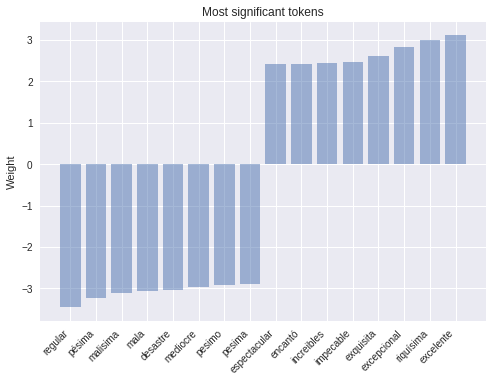

In [23]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i - index_offset]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()


## Vamos Deeper

### Fully connected

Acá podemos bifurcar los caminos, siguiendo complejizando los modelos lineales, uno de los grandes campeones de la clasificación de texto son los SVMs, con kernels no lineales, pero si queremos ir deeper, podemos agregar algunas capas intermedias...

In [27]:
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))

train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3isqf8hw/bow_embeddings', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f21d4fd57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tens

Podemos usar TensorBoard para visualizar los vectores que aprendió el modelos proyectados a $\mathbb{R}^3$ usando *t-SNE*. El siguiente código genera un archivo con los labels que podemos cargar para visualizar que vector corresponde a cada palabra.

![Embedding image](https://github.com/eisenjulian/nlp_estimator_tutorial/blob/master/embeddings.gif?raw=true)

In [0]:
#@markdown Descargar archivo de labels para los vectores
from google.colab import files
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    for i in range(index_offset + 1):
        f.write('<_{}_>\n'.format(i))
    for index in range(1, vocab_size - index_offset):
        f.write(word_inverted_index[index] + '\n')
files.download(os.path.join(model_dir, 'metadata.tsv'))

### Convoluciones

Las convoluciones apuntan a salirnos del modelo de bolsa de palabras para poder procesar ventanas de texto dentro de un documento.

![cnn](https://cdn-images-1.medium.com/max/1000/1*TsW55MIvzHwb-GRA21Q7Zw.png)

In [0]:
def get_cnn_logits(features, training, params):
  
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        trainable=params['embedding_trainable'],
        initializer=params['embedding_initializer'])
  
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    pool = tf.reduce_max(input_tensor=conv, axis=1) # Global Max Pooling
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    return tf.layers.dense(inputs=dropout_hidden, units=1)

![alt text](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/mermaid/cnn.png)

Un estimador se define a partir de una función `model_fn(features, labels, mode, params)`

In [0]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    training = mode == tf.estimator.ModeKeys.TRAIN
    
    logits = get_cnn_logits(features, training, params)

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=tf.reshape(labels, [-1, 1]) if labels is not None else None,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)

In [0]:
params = {
    'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0),
    'embedding_trainable': True
}

In [29]:
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43x26c8n/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febcc9d4588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Grap

### Transferencia de aprendizaje

Inicializamos el modelos con vectores random, por lo que debemos aprender a *hablar* de cero cada vez. Si usamos vectores pre-entranados podemos:

 * Aprender de datos sin etiquetar
 * Aprovechar mejor la poca data etiquetada que tenemos

In [30]:
#@title Cargar vectores pre-entrenados
#@markdown `embedding_matrix = load_fasttext_embeddings('wiki.es.vec')`

if not os.path.exists('wiki.es.vec'):
    ! wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.es.vec
      
def load_fasttext_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        f.readline()
        for line in f:
            values = line.strip().split()
            if not values[1][0] in '0123456789-':
                continue
            w = values[0]
            if w not in word_index or word_index[w] >= vocab_size:
                continue
            vectors = np.asarray(values[1:51], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i + index_offset < vocab_size:
            embedding_matrix[i + index_offset] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_fasttext_embeddings('wiki.es.vec')

--2018-10-20 03:54:13--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.es.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.237.37
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.237.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2594302560 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.es.vec’

wiki.es.vec         100%[===================>]   2.42G  62.7MB/s    in 41s     

2018-10-20 03:54:54 (60.0 MB/s) - ‘wiki.es.vec’ saved [2594302560/2594302560]

Successfully loaded pretrained embeddings for 4809/5000 words.


Ahora podemos cargar los vectores en nuestro modelo


In [31]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    return embedding_matrix

params = {'embedding_initializer': my_initializer, 'embedding_trainable': False}

cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
    model_dir=os.path.join(model_dir, 'cnn_pretrained'),
    params=params)
train_and_evaluate(cnn_pretrained_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43x26c8n/cnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febc86692b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tens

Podemos correr este modelo dejando re-entrenar los pesos o no. También hay papers que muestran que lo mejor es regalurazar hacie esos valores en lugar de solo usarlos como inicialización. En la práctica salvo excepciones dejarlos fijos es lo mejor para evitar overfitting, las mejoras que se obtienen son marginales.

In [32]:
params = {'embedding_initializer': my_initializer, 'embedding_trainable': True}
cnn_pretrained_classifier_reatrain = tf.estimator.Estimator(model_fn=cnn_model_fn,
    model_dir=os.path.join(model_dir, 'cnn_pretrained_retrain'),
    params=params)
train_and_evaluate(cnn_pretrained_classifier_reatrain)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43x26c8n/cnn_pretrained_retrain', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febc8669588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
I

### LSTMs

LSTMs son el más popular algoritmo de red neuronal recursiva para procesar secuencias. Una de las desventajas al comparar con CNNs es que, por la naturaleza de la recursión los modelos son mas profundos y complejos, que resulta en tiempos mas lentos de entrenamiento y peor convergencia.

![LSTM Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

In [0]:
def get_lstm_logits(features):
    # [batch_size x sentence_size x embedding_size]
    inputs = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

    # create an LSTM cell of size 100
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(100)
    
    # create the complete LSTM
    _, final_states = tf.nn.dynamic_rnn(
        lstm_cell, inputs, sequence_length=features['len'], dtype=tf.float32)

    # get the final hidden states of dimensionality [batch_size x sentence_size]
    outputs = final_states.h

    return tf.layers.dense(inputs=outputs, units=1)

In [0]:
#@markdown Definir `lstm_model_fn`

head = tf.contrib.estimator.binary_classification_head()

def lstm_model_fn(features, labels, mode):    
    
    logits = get_lstm_logits(features)

    optimizer = tf.train.AdamOptimizer()

    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=tf.reshape(labels, [-1, 1]) if labels is not None else None,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)

In [0]:
lstm_classifier = tf.estimator.Estimator(model_fn=lstm_model_fn,
                                         model_dir=os.path.join(model_dir, 'lstm'))
train_and_evaluate(lstm_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43x26c8n/lstm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febd387d630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Gra

Los **LSTM Networks** se han vuelto el caballito de batalla en muchos problemas de NLP, usando el output de cada unidad para armar módelos de lenguaje o la clasificar cada token de una oración.
 
Estos mismos módelos se pueden usar después de forma inversa para **generar texto**

## Resultados

Para ir cerrando, lo primero es como usar esto para sacar predicciones

In [33]:
#@title Making Predictions { run: "auto", vertical-output: true, display-mode: "form" }
doc1 = "La comida daba asco, estaba dura la carne, horrible!" #@param {type:"string"}
doc2 = "Estaba todo riquísimo, vale la pena" #@param {type:"string"}

tf.logging.set_verbosity(tf.logging.ERROR)

def print_predictions(sentences):
    indexes = [doc_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               padding='post', 
                               value=-1)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers:
            print("\t{0:.6f} {1}".format(predictions[path][idx].item(), os.path.basename(path)))
            
print_predictions([doc1, doc2])

La comida daba asco, estaba dura la carne, horrible!
	0.000395 bow_sparse
	0.000291 bow_sparse
	0.000000 cnn
	0.073282 cnn_pretrained
	0.000000 cnn_pretrained_retrain
Estaba todo riquísimo, vale la pena
	0.946516 bow_sparse
	0.933265 bow_sparse
	0.999999 cnn
	0.972757 cnn_pretrained
	0.999995 cnn_pretrained_retrain


### Corriendo TensorBoard

Ahora podemos correr TensorBoard y ver como los diferentes modelso que entramos se comparan entre sí en terminos de tiempo de entrenamiento y perforamnce.

En la terminal

> tensorboard --logdir={model_dir}

Podemos ver varias métricas durante entrenamiento y prueba, incluída la loss function de cada modelos durante el entenamiento y las PR curves.

## Otras herramientas

Otra herramienta muy útil es [Spacy](https://spacy.io) a la hora de trabajar sobre texto. Veamos que puede hacer...

In [0]:
! pip install -U spacy
! python -m spacy download es

In [0]:
import spacy
nlp = spacy.load('es')
from spacy import displacy
from spacy.matcher import Matcher

In [0]:
#@title Análisis de dependencias
sentence = "Los propietarios me trataron muy bien" #@param {type:"string"}
doc = nlp(sentence)
displacy.render(doc, style='dep', jupyter=True)

In [0]:
#@title Análisis de entidades
sentence = "La comida India era muy rica y estaba comiendo Fidel Castro." #@param {type:"string"}
doc = nlp(sentence)
displacy.render(doc, style='ent', jupyter=True)

También podemos buscar en un corpus grande frases que matchean ciertos patrones. Muy útil a la hora hacer benchmarks para datasets.

In [0]:
matched_sents = [] # collect data of matched sentences to be visualized
matcher = Matcher(nlp.vocab)
reviews = '\n'.join(list(get_docs('*'))[0:1000])

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start : end] # matched span
    sent = span.sent # sentence containing matched span
    # append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'MATCH'}]
    matched_sents.append({'text': sent.text, 'ents': match_ents })

pattern = [{'LOWER': 'comida'}, {'LEMMA': 'ser'}, {'POS': 'ADV', 'OP': '*'},
           {'POS': 'ADJ'}]
matcher.add('La comida', collect_sents, pattern) # add pattern
matches = matcher(nlp(reviews)) # match on your text
displacy.render(matched_sents, manual=True, jupyter=True, style='ent')

## Referencias

* [Natural Language Processing (almost) from Scratch](https://arxiv.org/abs/1103.0398) - *Paper fundacional a la hora de aplicar DNN a problemas de NLP*
 
* [Learning to Rank Short Text Pairs with Convolutional Deep Neural Networks by Severyn et al. 2015](https://www.semanticscholar.org/paper/Learning-to-Rank-Short-Text-Pairs-with-Deep-Neural-Severyn-Moschitti/452f7411af7d471dd3ba84c2b06b2aaffc38cdb9) - *Usa CNNs para generar representaciones de los textos*

* [Bag of Tricks for Efficient Text Classification
](https://arxiv.org/abs/1607.01759) - *Explica el modelos de fast text: buen transfer learning + ngram features + hierarchical softmak le gana muchos modelos mas complejos*

* [FastText pretrained vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)
 
* [Efficient Estimation of Word Representations in Vector Space
](https://arxiv.org/abs/1301.3781) -*Introduce los tests para medir la calidad de pesos a transferir*
 
* [Procesamiento de Lenguaje Natural en
Sistemas de Análisis de Sentimientos](http://materias.fi.uba.ar/7500/Dubiau.pdf)


<center>
  <br><br><br><br>
  <h1>¡Muchas gracias!</h1>
  <h2>¿Preguntas? ¿CVs?</h2>
  <br><br><br><br>
</center>
<table width="100%"><tbody><tr aligh="left">
      <td><img width="100" src="https://storage.googleapis.com/m-infra.appspot.com/public/botmaker/bmtop7.png"></td>
      <td align="right">20 de Octube de 2018 - DevFest Buenos Aires</td>
</tr></tbody></table>